In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
import os
import cv2

# load labelled data 
def load_labelled_dataset(path):
    data = load_files(path)
    classified_files = np.array(data['filenames'])
    return classified_files

#load unlabelled data
def load_unlabelled_dataset(path):
    images = []
    for dirpath, subdirs, files in os.walk(path):
        for name in files: 
            if name.endswith(".jpg"):
                images.append(os.path.join(dirpath, name))
    return images

# load datasets. labelled files will be used 
labelled_files = load_labelled_dataset('imgs/train')
unlabelled_files = load_unlabelled_dataset('imgs/test')

# load list of class names
categories = [item[20:-1] for item in sorted(glob("imgs/train/*/"))]

# print statistics about the dataset
print('There are %d total categories.' % len(categories))
print('There are %s total  images.\n' % len(np.hstack([labelled_files, unlabelled_files])))
print('There are %d labelled images.' % len(labelled_files))
print('There are %d unlabelled images.'% len(unlabelled_files))

Using TensorFlow backend.


There are 10 total categories.
There are 102150 total  images.

There are 22424 labelled images.
There are 79726 unlabelled images.


In [2]:
import pandas as pd

#read image names and labels from csv file
def get_driver_data():
    df = pd.read_csv('driver_imgs_list.csv')    
    return df

import numpy as np

#matches labels to images 
def match_labels_images(img_paths):
    df = get_driver_data()
    images = []
    labels = []
    for img_path in img_paths:
        image = img_path.split("/")
        im_name = image[-1]
        label = df['classname'][df['img']==im_name]
        str_label = str(label)
        images.append(img_path)
        labels.append(str_label)
    np_images = np.array(images)
    np_labels = np.array(labels)
    
    return np_images, np_labels

X_labelled, y_labelled = match_labels_images(labelled_files)

print(X_labelled.shape[0], 'labelled samples')

22424 labelled samples


In [3]:
safe_driving_labels = ['safe driving', 'texting - right', 'talking on the phone - right', 
                       'texting - left', 'talking on the phone - left', 'operating the radio', 
                       'drinking', 'reaching behind', 'hair and make-up', 'talking to passenger']

In [4]:
# retrieve class names from label values into numerical values 0,1,2,3,4,5,7,8 and 9
def split_target(y_labels):
    y_val =[]

    for y in y_labels:
        y = y.split("c")
        y = y[1].split("\n")
        y_val.append(y[0])
    return y_val# define text labels 


In [5]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [6]:
from keras.utils import np_utils

def reshape_labelled(X , y):
      
    data = np.array(paths_to_tensor(X), dtype=np.uint8)
    target = np.array(split_target(y), dtype=np.uint8)
    target = np_utils.to_categorical(target, 10)

    #Rescaling images by dividing every pixel in every image by 255
    data = data.astype('float32') / 255
    
    return data, target

def reshape_unlabelled(X):
    
    data = np.array(paths_to_tensor(X), dtype=np.uint8)  

    #Rescaling images by dividing every pixel in every image by 255
    data = data.astype('float32') / 255
    
    return data

# reshape train, validation and test datasets
X_labelled, y_labelled = reshape_labelled(X_labelled , y_labelled)

#we select some sample of unlabelled data to plot and see how our model does on unlabelled data
X_unlabelled = reshape_unlabelled(unlabelled_files[:100])

# print shape of training, validation and test.
print('X_labelled shape:', X_labelled.shape)


# print number of training and test images
print(X_labelled.shape[0], 'labelled samples')

# print shape of unlabelled set
print('X_unlabelled shape:', X_unlabelled.shape)

# print number of unlabelled images
print(X_unlabelled.shape[0], 'unlabelled samples')

100%|██████████| 100/100 [00:00<00:00, 208.82it/s]


X_labelled shape: (22424, 224, 224, 3)
22424 labelled samples
X_unlabelled shape: (100, 224, 224, 3)
100 unlabelled samples


In [7]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
sss.get_n_splits(X_labelled, y_labelled)

for train_index, test_index in sss.split(X_labelled, y_labelled):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X_labelled[train_index], X_labelled[test_index]
    y_train, y_test = y_labelled[train_index], y_labelled[test_index]

# print shape of training, validation and test.
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)


TRAIN: [  792 15364  4194 ...,  1985 10608 15519] TEST: [21867 22095 15043 ...,  9595 19994    96]
TRAIN: [ 3112 13350 17958 ..., 10231  7444 14097] TEST: [ 8704  6234 12297 ...,  8824  4461 12891]
TRAIN: [ 8827 10567  8858 ..., 11651 18869 18815] TEST: [14865  2417 14198 ..., 12239 20359 15250]
TRAIN: [17022  6467 13758 ..., 21514  5107 14591] TEST: [21795 16763 15778 ...,  7888 14997 13089]
TRAIN: [21930 11027 17972 ...,  7176 10544 21435] TEST: [ 9575 16804  3381 ..., 15569 19642 18920]
TRAIN: [ 1366 16079  6549 ..., 21094 18289 10517] TEST: [12571 19580 12662 ..., 19908 16946 13587]
TRAIN: [17591 21496 14813 ..., 14595 21527 16753] TEST: [17787  4383 14969 ...,  3152 21685  3168]
TRAIN: [ 3950 18467  6052 ..., 16019  3610  9561] TEST: [ 5287 18033  3494 ...,  4641   473 16474]
TRAIN: [17329 21586  4790 ...,  7495  5943   219] TEST: [19337  6149  3379 ..., 19363 19602 14461]
TRAIN: [17813 21570  2878 ..., 10382 14181 20224] TEST: [  839  7980 13306 ...,  4058  6993  1921]
X_train sh

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
sss.get_n_splits(X_train, y_train)

for train_index, test_index in sss.split(X_train, y_train):
    print("TRAIN:", train_index, "VALIDATION:", test_index)
    X_trn, X_validation = X_train[train_index], X_train[test_index]
    y_trn, y_validation = y_train[train_index], y_train[test_index]

# print shape of training, validation and test.
print('X_train shape:', X_trn.shape)
print('X_validation shape:', X_validation.shape)

TRAIN: [4376 4348 4565 ..., 3385  535  611] VALIDATION: [2774  290  531 ..., 5169  556 4478]
TRAIN: [4107 2773  227 ..., 1521 3134 1387] VALIDATION: [4845 1137 4805 ..., 3499 4385 1400]
TRAIN: [ 279 4894  744 ..., 1742 3662 5076] VALIDATION: [4655  902 1075 ..., 1682  377 2414]
TRAIN: [ 424  419 1734 ..., 2669 1183 2953] VALIDATION: [3131 2042 4102 ...,  704 3462  623]
TRAIN: [2276 4248  342 ..., 1360 1147 3159] VALIDATION: [3207 5194  692 ..., 2097 1172 1658]
TRAIN: [3977 2066 3690 ..., 3755 1234  777] VALIDATION: [2225 4111 4335 ..., 2363 3775  191]
TRAIN: [3189  196  373 ..., 2796 2179  126] VALIDATION: [4190  289 2317 ..., 3710  611 4806]
TRAIN: [ 452  193 1021 ..., 3809 2610 1305] VALIDATION: [3660 1413 4935 ..., 4029 4832 4685]
TRAIN: [3010 1739 1609 ...,  256 4968 1254] VALIDATION: [4858 1306 1317 ..., 3821  238 2647]
TRAIN: [5252 4012  480 ..., 2344 2454 2848] VALIDATION: [2564 5146  549 ..., 4610 2534 3669]
X_train shape: (4306, 224, 224, 3)
X_validation shape: (1077, 224, 224

In [14]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=2, padding='same',activation='relu',input_shape=(224, 224,3)))
model.add(Conv2D(filters=32, kernel_size=2, padding='same',activation='relu',input_shape=(224, 224,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0,5))
model.add(Conv2D(filters=64,kernel_size=2, padding='same',activation='relu'))
model.add(Conv2D(filters=64,kernel_size=2, padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0,5))
model.add(Conv2D(filters=128,kernel_size=2, padding='same',activation='relu'))
model.add(Conv2D(filters=128,kernel_size=2, padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0,5))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 32)      416       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 32)      4128      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 64)      8256      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 64)      16448     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 64)        0         
__________

In [15]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])


In [16]:
from keras.callbacks import ModelCheckpoint ,TensorBoard
checkpointer = ModelCheckpoint(filepath='model.weights.bestrefined.hdf5', verbose=1, save_best_only=True)
import keras
tensorboard = TensorBoard(log_dir="logs/refined/")

In [17]:

hist = model.fit(X_trn, y_trn, batch_size=32, epochs=10,
          validation_data=(X_validation, y_validation), callbacks=[checkpointer,tensorboard], 
          verbose=1, shuffle=True)

Train on 4306 samples, validate on 1077 samples
Epoch 1/10
4306/4306 [==============================] - 63s - loss: 2.0493 - acc: 0.2980 - val_loss: 1.1177 - val_acc: 0.6852
Epoch 2/10
4306/4306 [==============================] - 64s - loss: 0.4273 - acc: 0.8672 - val_loss: 0.1847 - val_acc: 0.9564
Epoch 3/10
4306/4306 [==============================] - 64s - loss: 0.1184 - acc: 0.9684 - val_loss: 0.1290 - val_acc: 0.9703
Epoch 4/10
4306/4306 [==============================] - 64s - loss: 0.0561 - acc: 0.9854 - val_loss: 0.1001 - val_acc: 0.9712
Epoch 5/10
4306/4306 [==============================] - 61s - loss: 0.0326 - acc: 0.9930 - val_loss: 0.1459 - val_acc: 0.9656
Epoch 6/10
4306/4306 [==============================] - 60s - loss: 0.0398 - acc: 0.9907 - val_loss: 0.5651 - val_acc: 0.8663
Epoch 7/10
4306/4306 [==============================] - 60s - loss: 0.0168 - acc: 0.9963 - val_loss: 0.2006 - val_acc: 0.9703
Epoch 8/10
4306/4306 [==============================] - 60s - loss: 0.

In [18]:
# evaluate and print test accuracy
score = model.evaluate(X_test, y_test, verbose=0)
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.946046373365


In [19]:
# get predictions on the test set
y_hat = model.predict(X_test)

In [20]:
from sklearn.metrics import log_loss
#Calculate logloss
log_loss = log_loss(y_test, y_hat)
print('\n', 'Log loss:', log_loss)


 Log loss: 0.773139418623


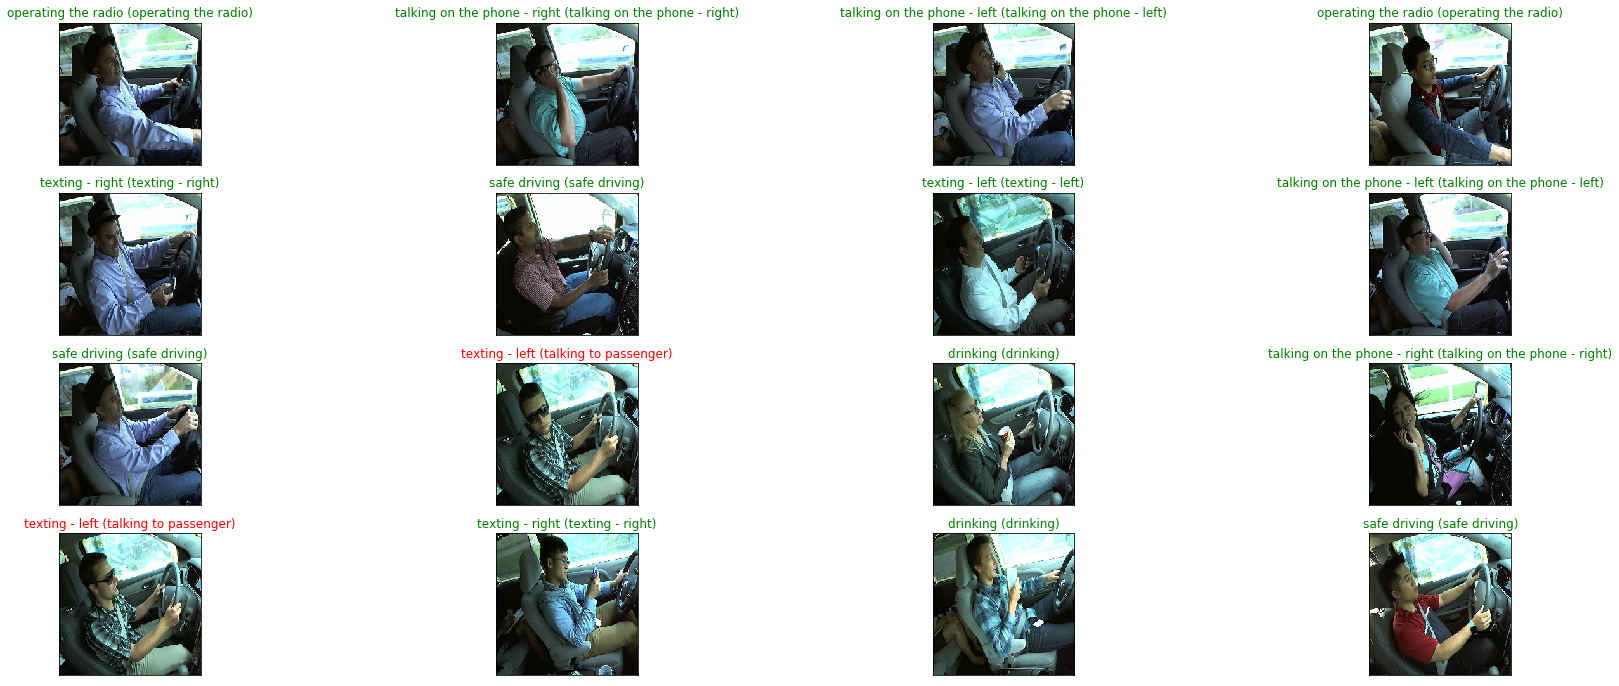

In [21]:
# plot a random sample of test images, their predicted labels, and ground truth
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(30, 12))
for i, idx in enumerate(np.random.choice(X_test.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(safe_driving_labels[pred_idx], safe_driving_labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))

In [22]:
# get predictions on the unlabelled set
y_unlabelled = model.predict(X_unlabelled)

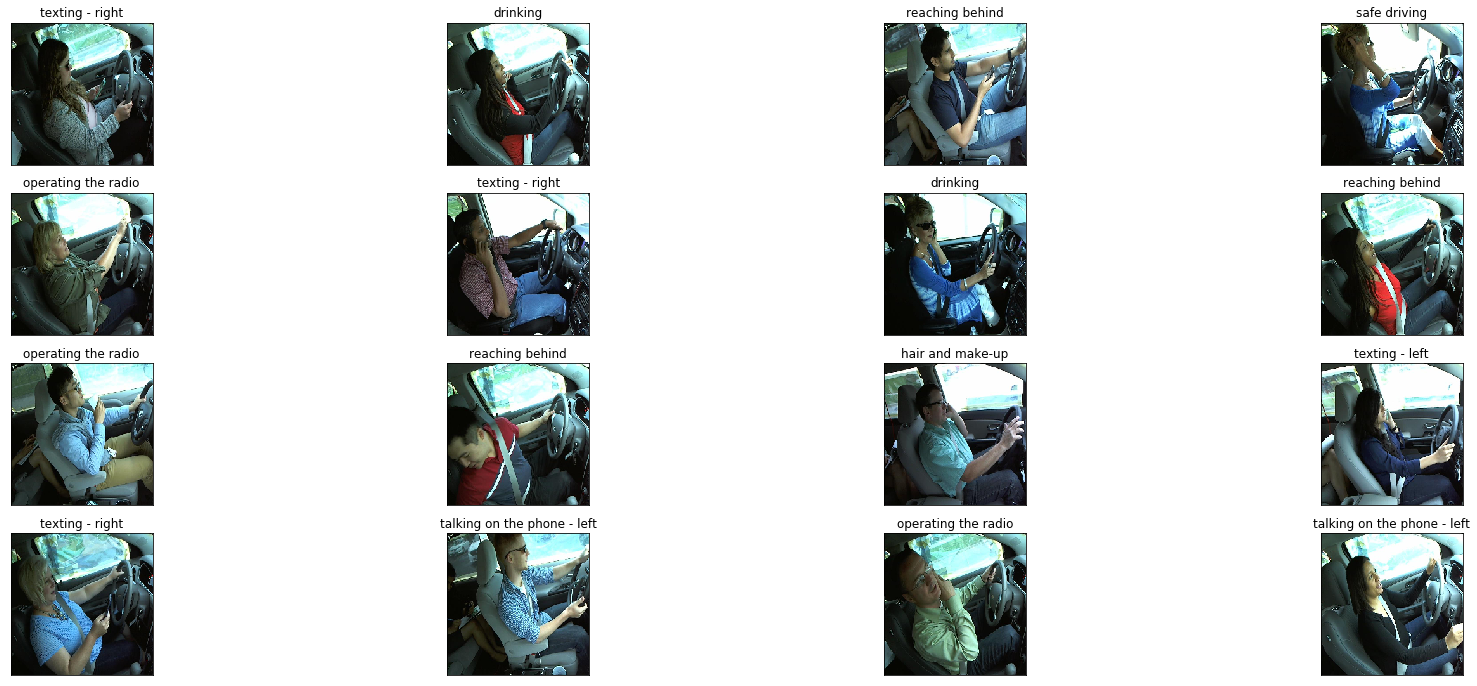

In [24]:
fig = plt.figure(figsize=(30, 12))
# plot a random sample predicted unlabelled images and predicted labels of those images.
for i, idx in enumerate(np.random.choice(X_unlabelled.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[idx]))
    pred_idx = np.argmax(y_unlabelled[idx])
    ax.set_title("{}".format(safe_driving_labels[pred_idx]))